In [1]:
import dgl
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from KGCN import Model, loss_fn
from sklearn.metrics import roc_auc_score

Using backend: pytorch


In [2]:
def process_graph(graph: dgl.heterograph):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ground_truth = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    user_repo = torch.zeros((number_of_users, number_of_repos), dtype=torch.int8)
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue

        edges = graph.edges(etype=etype)

        ground_truth[edges[0], edges[1]] = 1
        user_repo[edges[0], edges[1]] = 1
    
    repos_per_user = torch.sum(user_repo, axis=1)

    return ground_truth, repos_per_user.numpy()

In [3]:
def process_edge_data(graph, edge_data):
    number_of_users = graph.num_nodes('user')
    number_of_repos = graph.num_nodes('repo')
    ratings = np.zeros((number_of_users, number_of_repos))
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        edges = graph.edges(etype=etype)
        data = torch.squeeze(edge_data[etype]).numpy()
        ratings[edges[0], edges[1]] = np.maximum(ratings[edges[0], edges[1]], data)
    
    return ratings

In [4]:
def compute_auc(graph, pos_score, neg_score):
    auc_scores = []
    for etype in graph.canonical_etypes:
        # ignore the reverse relation
        if etype[0] != 'user' and etype[1] != 'repo':
            continue
        
        pos_data = torch.squeeze(pos_score[etype])
        neg_data = torch.squeeze(neg_score[etype])
        
        scores = torch.cat([pos_data, neg_data]).numpy()
        labels = torch.cat(
            [torch.ones(pos_data.shape[0]), torch.zeros(neg_data.shape[0])]).numpy()

        auc_score = roc_auc_score(labels, scores)

        auc_scores.append(auc_score)
    
    return np.mean(auc_scores)

In [5]:
training_results = []

EPOCH = 100
TOP_K = 10
NEG_SAMPLE_SIZE = 5
USER_INPUT_SIZE = 150
REPO_INPUT_SIZE = 361
USER_REPO_OUTPUT_SIZE = 125
HIDDEN_OUTPUT_SIZE = 96
OUT_SIZE = 50

g, l = dgl.load_graphs('./data/sub_kowledge_graph.bin')
train_graph = g[0]
valid_graph = g[1]
test_graph = g[2]
train_pos_g = g[3]
train_neg_g = g[4]
valid_pos_g = g[5]
valid_neg_g = g[6]
test_pos_g = g[7]
test_neg_g = g[8]

model = Model(train_graph, USER_INPUT_SIZE, REPO_INPUT_SIZE, USER_REPO_OUTPUT_SIZE, HIDDEN_OUTPUT_SIZE, OUT_SIZE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

ground_truth_valid_data, repos_per_user_valid = process_graph(valid_graph)
ground_truth_test_data, repos_per_user_test = process_graph(test_graph)

for epoch in range(EPOCH):
    training_loops = 0
    total_loss = 0

    user_feat = train_graph.ndata['graph_data']['user']
    repo_feat = train_graph.ndata['graph_data']['repo']
    model.train()
    pos_score, neg_score = model(train_graph, train_pos_g, train_neg_g, user_feat, repo_feat)
    loss = loss_fn(pos_score, neg_score, NEG_SAMPLE_SIZE)

    total_loss += loss.item()
    training_loops += 1

    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_avg_loss = total_loss / training_loops

    if epoch % 5 == 0:
        # # valid top k recommendation
        valid_mean_hit_rate = 0
        valid_group_0_5_hit_rate = 0
        valid_group_5_10_hit_rate = 0
        valid_group_10_15_hit_rate = 0
        valid_group_15_over_hit_rate = 0
        model.eval()
        with torch.no_grad():
            hit_rates = np.zeros(valid_graph.num_nodes('user'))
            group_0_5 = []
            group_5_10 = []
            group_10_15 = []
            group_15_over = []
        
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(valid_graph, out)
            user_repo_rating = process_edge_data(valid_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating
                recommendation = recommendation.argsort()[-TOP_K:]
                ground_truth = np.where(ground_truth_valid_data[i]>0)[0]

                recommendation_set = set(recommendation)
                ground_truth_set = set(ground_truth)

                intersections = recommendation_set.intersection(ground_truth_set)
                number_of_intersections = len(intersections)
                number_of_ground_truth = len(ground_truth_set)
                hit_rate = -1 if number_of_ground_truth == 0 else number_of_intersections / min(number_of_ground_truth, TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # grouping
                if repos_per_user_valid[i] < 5:
                    group_0_5.append(i)
                elif repos_per_user_valid[i] < 10:
                    group_5_10.append(i)
                elif repos_per_user_valid[i] < 15:
                    group_10_15.append(i)
                else:
                    group_15_over.append(i)

            valid_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            valid_group_0_5_hit_rate = np.mean(hit_rates[group_0_5][hit_rates[group_0_5]>-1])
            valid_group_5_10_hit_rate = np.mean(hit_rates[group_5_10][hit_rates[group_5_10]>-1])
            valid_group_10_15_hit_rate = np.mean(hit_rates[group_10_15][hit_rates[group_10_15]>-1])
            valid_group_15_over_hit_rate = np.mean(hit_rates[group_15_over][hit_rates[group_15_over]>-1])
        
        # # test top k recommendation
        test_mean_hit_rate = 0
        test_group_0_5_hit_rate = 0
        test_group_5_10_hit_rate = 0
        test_group_10_15_hit_rate = 0
        test_group_15_over_hit_rate = 0
        model.eval()
        with torch.no_grad():
            hit_rates = np.zeros(test_graph.num_nodes('user'))
            group_0_5 = []
            group_5_10 = []
            group_10_15 = []
            group_15_over = []
        
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            prediction = model.predict(test_graph, out)
            user_repo_rating = process_edge_data(test_graph, prediction)

            for i, rating in enumerate(user_repo_rating):
                recommendation = rating
                recommendation = recommendation.argsort()[-TOP_K:]
                ground_truth = np.where(ground_truth_test_data[i]>0)[0]

                recommendation_set = set(recommendation)
                ground_truth_set = set(ground_truth)

                intersections = recommendation_set.intersection(ground_truth_set)
                hit_rate = -1 if len(ground_truth_set) == 0 else len(intersections) / min(len(ground_truth_set), TOP_K)
                hit_rates[i] = min(hit_rate, 1)

                # grouping
                if repos_per_user_test[i] < 5:
                    group_0_5.append(i)
                elif repos_per_user_test[i] < 10:
                    group_5_10.append(i)
                elif repos_per_user_test[i] < 15:
                    group_10_15.append(i)
                else:
                    group_15_over.append(i)

            test_mean_hit_rate = np.mean(hit_rates[hit_rates>-1])
            test_group_0_5_hit_rate = np.mean(hit_rates[group_0_5][hit_rates[group_0_5]>-1])
            test_group_5_10_hit_rate = np.mean(hit_rates[group_5_10][hit_rates[group_5_10]>-1])
            test_group_10_15_hit_rate = np.mean(hit_rates[group_10_15][hit_rates[group_10_15]>-1])
            test_group_15_over_hit_rate = np.mean(hit_rates[group_15_over][hit_rates[group_15_over]>-1])
        
        # conpute the AUC score
        auc_score = 0
        model.eval()
        with torch.no_grad():
            h_user = model.user_embedding(train_graph.ndata['graph_data']['user'])
            h_repo = model.repo_embedding(train_graph.ndata['graph_data']['repo'])

            h_dict = {
                'user': h_user,
                'repo': h_repo
            }

            h = model.hidden(train_graph, h_dict)
            out = model.out(train_graph, h)

            pos_score = model.predict(test_pos_g, out)
            neg_score = model.predict(test_neg_g, out)

            auc_score = compute_auc(train_graph, pos_score, neg_score)

        training_results.append([epoch, 
                                 train_avg_loss, 
                                 auc_score,
                                 valid_mean_hit_rate, 
                                 test_mean_hit_rate, 
                                 valid_group_0_5_hit_rate, 
                                 valid_group_5_10_hit_rate, 
                                 valid_group_10_15_hit_rate, 
                                 valid_group_15_over_hit_rate, 
                                 test_group_0_5_hit_rate, 
                                 test_group_5_10_hit_rate, 
                                 test_group_10_15_hit_rate, 
                                 test_group_15_over_hit_rate])

In [6]:
data = pd.DataFrame(training_results, 
                    columns=['epoch', 
                             'loss', 
                             'auc',
                             'valid hit rate', 
                             'test hit rate', 
                             'valid group 0 to 5', 
                             'valid group 5 to 10', 
                             'valid group 10 to 15', 
                             'valid group 15 over', 
                             'test group 0 to 5', 
                             'test group 5 to 10', 
                             'test group 10 to 15', 
                             'test group 15 over'])

In [7]:
data

,epoch,loss,auc,valid hit rate,test hit rate,valid group 0 to 5,valid group 5 to 10,valid group 10 to 15,valid group 15 over,test group 0 to 5,test group 5 to 10,test group 10 to 15,test group 15 over
0,0,0.345571,0.492574,0.739817,0.739225,0.762127,0.510125,0.455357,0.605556,0.761036,0.499232,0.466667,0.695238
1,5,0.057059,0.644660,0.738470,0.732724,0.761761,0.483149,0.462500,0.616667,0.756225,0.458010,0.461404,0.695238
2,10,0.044789,0.680321,0.741527,0.741036,0.764873,0.487502,0.462500,0.616667,0.764997,0.464532,0.461404,0.695238
3,15,0.039196,0.691280,0.733884,0.729527,0.756910,0.480028,0.462500,0.616667,0.753113,0.453740,0.456140,0.695238
4,20,0.036555,0.687657,0.734904,0.733292,0.757917,0.482090,0.462500,0.616667,0.757168,0.455098,0.456140,0.695238
5,25,0.033947,0.697199,0.734821,0.735295,0.756910,0.489993,0.482143,0.605556,0.757263,0.490041,0.466667,0.690476
6,30,0.032149,0.685518,0.741103,0.741397,0.760754,0.516941,0.494643,0.727778,0.761224,0.508717,0.514035,0.709524
7,35,0.030769,0.673044,0.739678,0.739257,0.761486,0.501763,0.457143,0.694444,0.761507,0.503886,0.475439,0.614286
8,40,0.029713,0.675410,0.737854,0.737278,0.759107,0.501763,0.458929,0.727778,0.758772,0.503886,0.482456,0.642857
9,45,0.028807,0.684140,0.740167,0.740760,0.757505,0.516454,0.546429,0.794444,0.758489,0.514156,0.561404,0.728571


Text(0.5, 1.0, 'Loss per epoch')

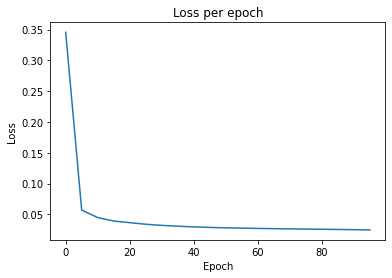

In [8]:
plt.plot(data['epoch'], data['loss'], label='loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epoch')

Text(0.5, 1.0, 'AUC per epoch')

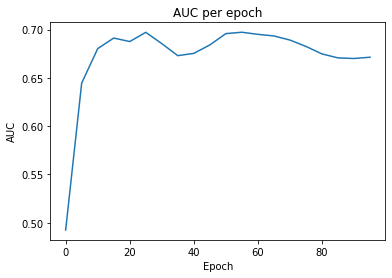

In [9]:
plt.plot(data['epoch'], data['auc'], label='auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC per epoch')

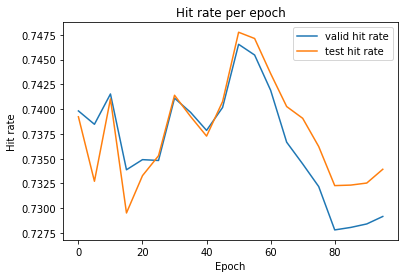

In [10]:
plt.plot(data['epoch'], data['valid hit rate'], label='valid hit rate')
plt.plot(data['epoch'], data['test hit rate'], label='test hit rate')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch')
plt.legend()

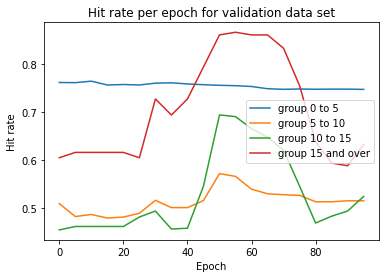

In [11]:
plt.plot(data['epoch'], data['valid group 0 to 5'], label='group 0 to 5')
plt.plot(data['epoch'], data['valid group 5 to 10'], label='group 5 to 10')
plt.plot(data['epoch'], data['valid group 10 to 15'], label='group 10 to 15')
plt.plot(data['epoch'], data['valid group 15 over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch for validation data set')
plt.legend()

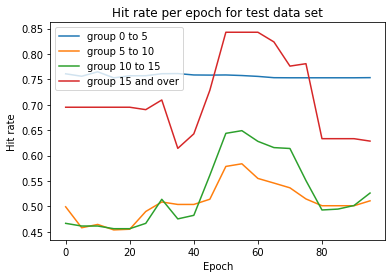

In [12]:
plt.plot(data['epoch'], data['test group 0 to 5'], label='group 0 to 5')
plt.plot(data['epoch'], data['test group 5 to 10'], label='group 5 to 10')
plt.plot(data['epoch'], data['test group 10 to 15'], label='group 10 to 15')
plt.plot(data['epoch'], data['test group 15 over'], label='group 15 and over')
plt.xlabel('Epoch')
plt.ylabel('Hit rate')
plt.title('Hit rate per epoch for test data set')
plt.legend()